In [3]:
import pandas as pd
import numpy as np
import datadotworld as ddw

from fuzzywuzzy import process

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict
from scipy.stats import pearsonr
import qgrid

from sklearn.preprocessing import MinMaxScaler



In [134]:
%watermark -n -v -p pandas,numpy,matplotlib.pyplot,datadotworld,sklearn

Mon Apr 03 2017 

CPython 3.6.0
IPython 5.3.0

pandas 0.18.1
numpy 1.12.1
matplotlib.pyplot 2.0.0
datadotworld 1.0.0-beta.3
sklearn 0.18.1


In [115]:
def prep():

    Gdf = ddw.query("nrippner/my-footprint-data", "select * from GDP_total_USD_2010")
    Gdf = Gdf.dataframe
    Gdf = Gdf.drop(['2014','2015','1960'], axis=1) 
    Gdf = pd.melt(Gdf, id_vars=['Country Name'], value_vars=list(Gdf.columns[4:].values),
           var_name='year', value_name='GDP')
    Gdf['year'] = Gdf.year.apply(lambda x: int(x))
    Gdf = Gdf[Gdf.year >= 1961]
    Gdf.columns = ['Country', 'year', 'GDP']
    
    EFCdf = ddw.query('nrippner/my-footprint-data','select * from `NFA 2017 Edition`')
    EFCdf = EFCdf.dataframe
    EFCdf.rename(columns={'country':'Country'}, inplace=True)

    t = pd.DataFrame({country:sum(Gdf[Gdf.Country == country].GDP.notnull()) for country in Gdf.Country.unique()},
                index=[0])
    t = t.T
    t = t.reset_index()
    t.columns = ['country', 'value']

    def remove(c, dataframe):
        dataframe = dataframe[dataframe.Country != c]
        return dataframe
    
    for i in t.country[t.value == 0].values:
        Gdf = remove(i, Gdf)
 
    repl = { 'Country':
               {'Gambia, The':'Gambia',
                'Iran, Islamic Rep.':'Iran, Islamic Republic of',
                'Korea, Rep.':'Korea, Republic of',
                'Lao PDR':'Lao People\'s Democratic Republic',
                'Libya':'Libyan Arab Jamahiriya',
                'Macedonia, FYR':'Macedonia TFYR',
                'Bahamas, The':'Bahamas',
                'St. Kitts and Nevis':'Saint Kitts and Nevis',
                'St. Lucia':'Saint Lucia',
                'Tanzania':'Tanzania, United Republic of',
                'United States':'United States of America',
                'Venezuela, RB':'Venezuela, Bolivarian Republic of',
                'Vietnam':'Viet Nam',
                'Yemen, Rep.':'Yemen',
                'Congo, Dem. Rep.':'Congo, Democratic Republic of',
                'Congo, Rep.':'Congo',
                'Cote d\'Ivoire':'Côte d\'Ivoire',
                'Egypt, Arab Rep.':'Egypt'
               }
               
            }

    Gdf.replace(repl, inplace=True)
    Gdf = Gdf.merge(EFCdf, how='inner', on=['Country', 'year'])
    Gdf = Gdf[Gdf.record == 'EFConsTotGHA']
    Gdf.reset_index(drop=True, inplace=True)
    Gdf = Gdf.set_index(['Country','year'])
    Gdf = Gdf.sort_index(level=0)
    Gdf = Gdf.reset_index()

    return Gdf

In [116]:
def test_prep(test, min_year, max_year):
    test['GDP'].fillna(np.nan, inplace=True)

    td = defaultdict(list)
    
    for country in test.Country.unique():
        try:
            td['GDPmin'].append(test[(test.year == min_year) & (test.Country == country)]['GDP'].values[0])
        except:
            td['GDPmin'].append(np.nan)
        try:
            td['GDPmax'].append(test[(test.year == max_year) & (test.Country == country)]['GDP'].values[0])
        except:
            td['GDPmax'].append(np.nan)
        try:
            td['EFmin'].append(test[(test.year == min_year) & (test.Country == country)]['total'].values[0])
        except:
            td['EFmin'].append(np.nan)
        try:
            td['EFmax'].append(test[(test.year == max_year) & (test.Country == country)]['total'].values[0])
        except:
            td['EFmax'].append(np.nan)

    td['Country'] = test.Country.unique()   

    diffdf = pd.DataFrame(td)

    diffdf['EFDelta'] = diffdf.EFmax - diffdf.EFmin
    diffdf['GDPDelta'] = diffdf.GDPmax - diffdf.GDPmin
    diffdf['DDelta'] = diffdf.GDPDelta - diffdf.EFDelta

    diffdf['EFDelta_P'] = diffdf.EFDelta / diffdf.EFmin * 100.0
    diffdf['GDPDelta_P'] = diffdf.GDPDelta / diffdf.GDPmin * 100.0
    diffdf['DDelta_P'] = diffdf.GDPDelta_P - diffdf.EFDelta_P

    diffdf.columns = [col.replace("max", str(max_year)) for col in diffdf.columns]
    diffdf.columns = [col.replace("min", str(min_year)) for col in diffdf.columns]

    diffdf['DDelta_Rank'] = diffdf.DDelta_P.rank(ascending=False)
    diffdf['EFDelta_Rank'] = diffdf.EFDelta_P.rank()
    diffdf['GDPDelta_Rank'] = diffdf.GDPDelta_P.rank()

    diffdf['Dec_Flag'] = np.nan
    diffdf['Dec_Flag'][(diffdf.EFDelta <= 0) & (diffdf.GDPDelta >= 0)] = 1
    diffdf['Dec_Flag'][(diffdf.EFDelta >0) | (diffdf.GDPDelta < 0)] = 0

    diffdf = diffdf[~(diffdf.DDelta.isnull())]
    diffdf = diffdf[diffdf.Country != 'World']
    repl = {'Country': {'Congo, Democratic Republic of':'Congo', 'Venezuela, Bolivarian Republic of':'Venezuela',
                        'Lao People\'s Democratic Republic':'Laos', 'Tanzania, United Republic of':'Tanzania',
                        'Iran, Islamic Republic of':'Iran'
                       }
           }
    diffdf.replace(repl, inplace=True)
    ssc = MinMaxScaler(feature_range=(25,2500))
    diffdf['GDP_std'] = ssc.fit_transform(diffdf.GDP2013.reshape(-1, 1))
    diffdf.reset_index(drop=True,inplace=True)
    return diffdf

In [117]:
def dplot(diffdf, min_year, max_year):   
     
    fig, ax = plt.subplots(figsize=(16,14))
    sns.regplot(data=diffdf, x='GDPDelta_Rank', y='EFDelta_Rank', scatter_kws={'s':diffdf.GDP_std,'color':'b'}, 
                fit_reg=False, ax=ax)
    plt.title('Growth in GDP vs. Ecological Footprint\n%s - %s' \
              % (min_year, max_year), fontsize=20)
    plt.xlabel('GDP Growth', fontsize=18)
    plt.ylabel('Ecological Footprint Growth', fontsize=18)
    
    xlocs, xlabels = plt.xticks()
    xlabels = [x.get_text() for x in xlabels]
    xlabels[1:-2] = \
       ['%.2f%s' % (diffdf.GDPDelta_P.sort_values().reset_index(drop=True)[i], '%') for i in xlocs[1:-2]]
    xlabels[-2] = '%.2f%s' % (diffdf.GDPDelta_P.sort_values().reset_index(drop=True).values[-1], '%')
    xlocs[-2] = 154
    plt.xticks(xlocs[1:-1], xlabels[1:-1], fontsize=14)
    
    ylocs, ylabels = plt.yticks()
    ylabels = [x.get_text() for x in ylabels]
    ylabels[1:-2] = ['%.2f%s' % (diffdf.EFDelta_P.sort_values().reset_index(drop=True)[i], '%') for i in ylocs[1:-2]]
    ylabels[-2] = '%.2f%s' % (diffdf.EFDelta_P.sort_values(ascending=False).reset_index(drop=True).values[0], '%')
    ylocs[-2] = 156
    plt.yticks(ylocs[1:-1], ylabels[1:-1], fontsize=14)
    
    downs = ['Jordan', 'Iran', 'Austria', 'Morocco', 'Samoa', 'Guinea-Bissau',
            'Barbados', 'Cyprus', 'Venezuela', 'Serbia', 'Madagascar', 'Rwanda',
            'El Salvador', 'Sweden']
    ups = ['Dominican Republic', 'India', 'Haiti', 'Netherlands', 'Switzerland', 'Lebanon',
          'Botswana', 'South Africa', 'Poland', 'Czech Republic', 'Cuba', 'Nepal',
          'Spain', 'Portugal', 'Dominica', 'Greece', 'Ukraine', 'Slovenia', 'Hungary',
          'Latvia']
    
    for i, txt in enumerate(diffdf.Country.values):
        if txt in downs:
            ax.annotate(txt, (diffdf.GDPDelta_Rank[i]+0.8, diffdf.EFDelta_Rank[i]),size=13, color='k',
                   ha='left', va='top')
        elif txt in ups:
            ax.annotate(txt, (diffdf.GDPDelta_Rank[i]+0.8, diffdf.EFDelta_Rank[i]),size=13, color='k',
                   ha='left', va='bottom')
        elif txt in ['Canada', 'Brazil', 'Italy', 'France', 'China', 'Russian Federation',
                    'United Kingdom', 'Japan', 'Australia', 'Mexico', 'Germany']:
            ax.annotate(txt, (diffdf.GDPDelta_Rank[i]+2, diffdf.EFDelta_Rank[i]), size=13, color='k',
                       ha='left', va='center')
        elif txt in ['United States of America']:
            ax.annotate(txt, (diffdf.GDPDelta_Rank[i]+4.2, diffdf.EFDelta_Rank[i]), size=13, color='k',
                       ha='left', va='bottom')
        
        else:
            ax.annotate(txt, (diffdf.GDPDelta_Rank[i]+0.8, diffdf.EFDelta_Rank[i]),size=13, color='k',
                   ha='left', va='center')
            
        

    
    bbox_props = dict(boxstyle="round", facecolor='lightgray',ec='k', lw=1)  
    ax.annotate('n=107\n(+)EF, (+)GDP', xy=(40, 155), size=14, bbox=bbox_props)
    ax.annotate('n=36\n(-)EF, (+)GDP', xy=(142, -2), size=14, bbox=bbox_props)
    ax.annotate('n=9\n(-)EF, (-)GDP', xy=(-5, 39), size=13, bbox=bbox_props)
    ax.annotate('n=1\n(+)EF, (-)GDP', xy=(-5, 155), size=13, bbox=bbox_props)
    plt.axhline(y=45.5, ls='-.', c='b')
    plt.axvline(x=10.5, ls='-.', c='b')
              
    plt.tight_layout()
    plt.show()
    

In [118]:
diffdf = test_prep(test=prep(), min_year=2009, max_year=2013)

/Users/noahrippner/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  if __name__ == '__main__':
/Users/noahrippner/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/noahrippner/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


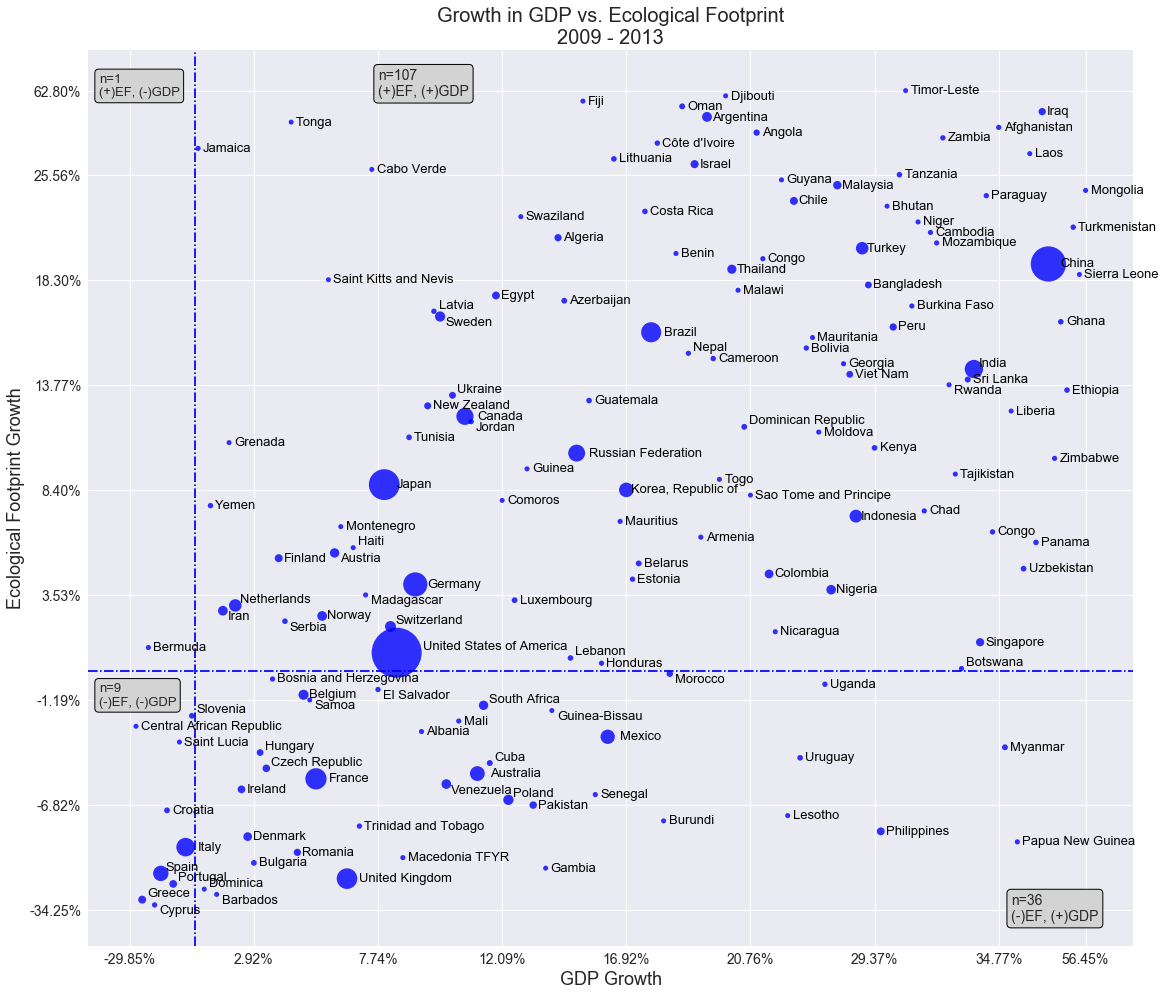

In [119]:
dplot(diffdf, '2009', '2013')

In [54]:
#diffdf.to_csv('EF_GDP(constant2010USD).csv', index=False)